# Mitigación de errores
En este notebook vamos a ver cómo aplicar la mitigación de errores de lectura usando qiskit experiments.

Empezamos construyendo el circuito sobre el que vamos a hacer la mitigación.

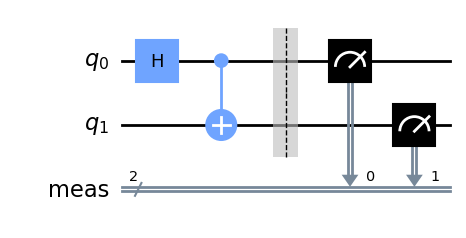

In [1]:
from qiskit import QuantumCircuit

#Construimos un circuito 
circ = QuantumCircuit(2) 
circ.h(0) 
circ.cx(0, 1) 
circ.measure_all() 
circ.draw()

Elijo el backend sobre el que se va a ejecutar.

In [2]:
from qiskit_ibm_provider import IBMProvider

provider=IBMProvider()
backend=provider.get_backend('ibm_kyoto')

Transpilo el circuito para ese backend para ver cuáles son los quits físicos que se van a usar

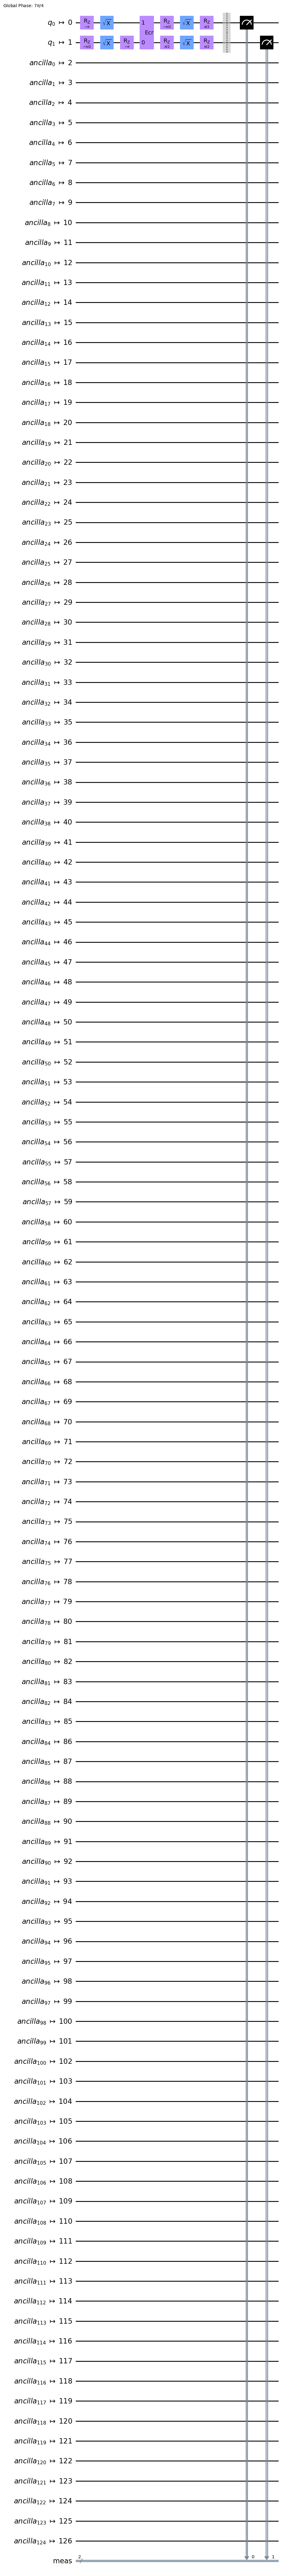

In [3]:
from qiskit import transpile

tcirc=transpile(circ,backend)
tcirc.draw()

Veo que el circuito se mapea sobre los qubits físicos 0 y 1.

Utilizo el experimento CorrelatedReadoutError de la librería de qiskit experiments para caracterizar los errores de lectura.

Como primer paso, inicializo el experimento (exp), especificando los qubits y el backend que se van a caracterizar. 

In [4]:
from qiskit_experiments.library import CorrelatedReadoutError

#Inicializo el experimento
physical_qubits=[0,1]
exp=CorrelatedReadoutError(physical_qubits,backend)

El experimento generará todos los circuitos que se van a utilizar para la caracterización. Esos circuitos se pueden consultar con el método circuits().

In [5]:
for c in exp.circuits():
    print(c)

         ░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas: 2/════╩══╩═
            0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
   q_1: ──────░──╫─┤M├
              ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
              ░ ┌─┐   
   q_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 


A continuación ejecuto el experimento utilizando para ello el método run(). Como resultado obtengo los datos del experimento (exp_data). 

In [6]:
#Ejecuto el experimento y realizo el analisis de los datos
exp_data=exp.run(backend,shots=10000)

Para acceder a los resultados de los análisis utilizamos el método analysis_results(indice). Donde índice es el índice del resultado del análisis que queremos obtener. En este experimento solamente tenemos un resultado, el "readout error mitigator", por lo que el índice utilizado será el 0.

In [7]:
#Obtengo el readout error mitigator
mitigator=exp_data.analysis_results(0).value

Ahora voy a utilizar el mitigador para mitigar los errores de lectura. Primero tengo que ejecutar el circuito sobre el backend y obtener las salidas con ruido.

In [ ]:
job=backend.run(tcirc, shots=10000)

In [10]:
#Recupero los resultados almacenados en la plataforma
job=provider.retrieve_job('cntbtd9vn4c0008a3nw0')

In [11]:
result=job.result()
counts_noisy=result.get_counts()
print(counts_noisy)

{'10': 540, '00': 4520, '11': 4554, '01': 386}


Calculo las probabilidades a partir de los counts:

In [13]:
prob_noisy = {string:count/10000 for string,count in counts_noisy.items()}
print(prob_noisy)

{'10': 0.054, '00': 0.452, '11': 0.4554, '01': 0.0386}


Aplico la mitigación a los resultados originales para obtener las probabilidades mitigadas.

El mitigador se puede utilizar para mitigar las cuasi probabilidades o los valores esperados. 

Para mitigar las cuasi probabilidades se utiliza el método quasi_probabilities(). 

In [14]:
#Aplico la mitigación a los resultados originales 
#para obtener las probabilidades mitigadas
prob_mitigated=mitigator.quasi_probabilities(counts_noisy,physical_qubits)
print(prob_mitigated)

{0: 0.5648202875217787, 1: -0.051352381707315126, 2: -0.027883658642451223, 3: 0.5144157528279876}


Las probabilidades se ofrecen en formato clave-valor, donde las claves representan un valor clásico medido y el valor es un float para la cuasi probabilidad de ese resultado. Las claves se pueden expresar en varios formatos: hexadecinal, binario y entero. Por defecto utiliza el formato entero. Si lo queremos pasar a binario podemos usar el método binary_probabilities(). 

In [15]:
#Utilizo el método binary_probabilities 
#para convertir las claves a binario
prob_mitigated_binary=prob_mitigated.binary_probabilities()
print(prob_mitigated_binary)

{'00': 0.5648202875217787, '01': -0.051352381707315126, '10': -0.027883658642451223, '11': 0.5144157528279876}


Dibujo los resultados obtenidos. Vemos que los datos mitigados se aproximan mucho a los resultados ideales. 

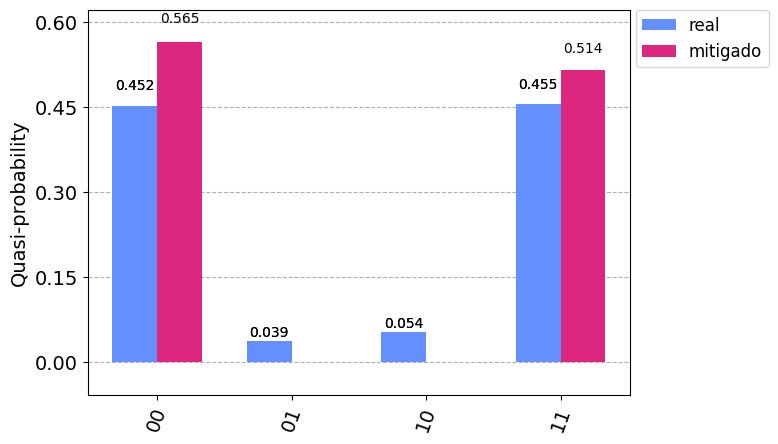

In [16]:
from qiskit.visualization import plot_distribution
plot_distribution([prob_noisy,prob_mitigated_binary], legend=['real','mitigado'])

También podríamos obtener las matrices de asignación y de mitigación

In [17]:
#Imprimo la matriz de asignacion
MA=mitigator.assignment_matrix(physical_qubits)
print(MA)

[[0.8061 0.0967 0.0547 0.0062]
 [0.0968 0.5554 0.2639 0.0385]
 [0.0827 0.2568 0.5552 0.0699]
 [0.0144 0.0911 0.1262 0.8854]]


In [18]:
#Imprimo la matrix de mitigación
MM=mitigator.mitigation_matrix(physical_qubits)
print(MM)

[[ 1.26828877e+00 -2.09142691e-01 -2.60611922e-02  2.27047724e-03]
 [-1.68418840e-01  2.33650446e+00 -1.09075187e+00 -1.43072840e-02]
 [-1.12624387e-01 -1.03835907e+00  2.33730704e+00 -1.38584444e-01]
 [ 1.27544564e-02 -8.90026955e-02 -2.20493983e-01  1.15062125e+00]]


In [19]:
import qiskit.tools.jupyter
%qiskit_version_table